# Display Matrix

This notebook shows the differents similarites matrix and compare the correlations between them.

Results are explained in Section 4.3.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import (
    compute_ndcg_similarity,
    compute_shap_similarity_pearson,
    compute_score_correlations,
    compute_pred_jaccard,
    plot_heatmaps,
    load_nested_results,
)
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch

In [3]:
all_results = load_nested_results("results/")

In [4]:
all_pearson = []
all_ndcg = []
all_corr_score = []
all_jaccard = []

for dataset_name, results in all_results.items():
    print(dataset_name)

    # Compute all matrices and store them
    pearson_matrix, model_names = compute_shap_similarity_pearson(results)
    ndcg_matrix, _ = compute_ndcg_similarity(results)
    corr_score_matrix, _ = compute_score_correlations(results)
    jaccard_matrix, _ = compute_pred_jaccard(results)

    all_pearson.append(pearson_matrix)
    all_ndcg.append(ndcg_matrix)
    all_corr_score.append(corr_score_matrix)
    all_jaccard.append(jaccard_matrix)

2_annthyroid
4_breastw
14_glass
15_Hepatitis
21_Lymphography
23_mammography
27_PageBlocks
29_Pima
37_Stamps
38_thyroid
39_vertebral
40_vowels
42_WBC
44_Wilt
45_wine
47_yeast


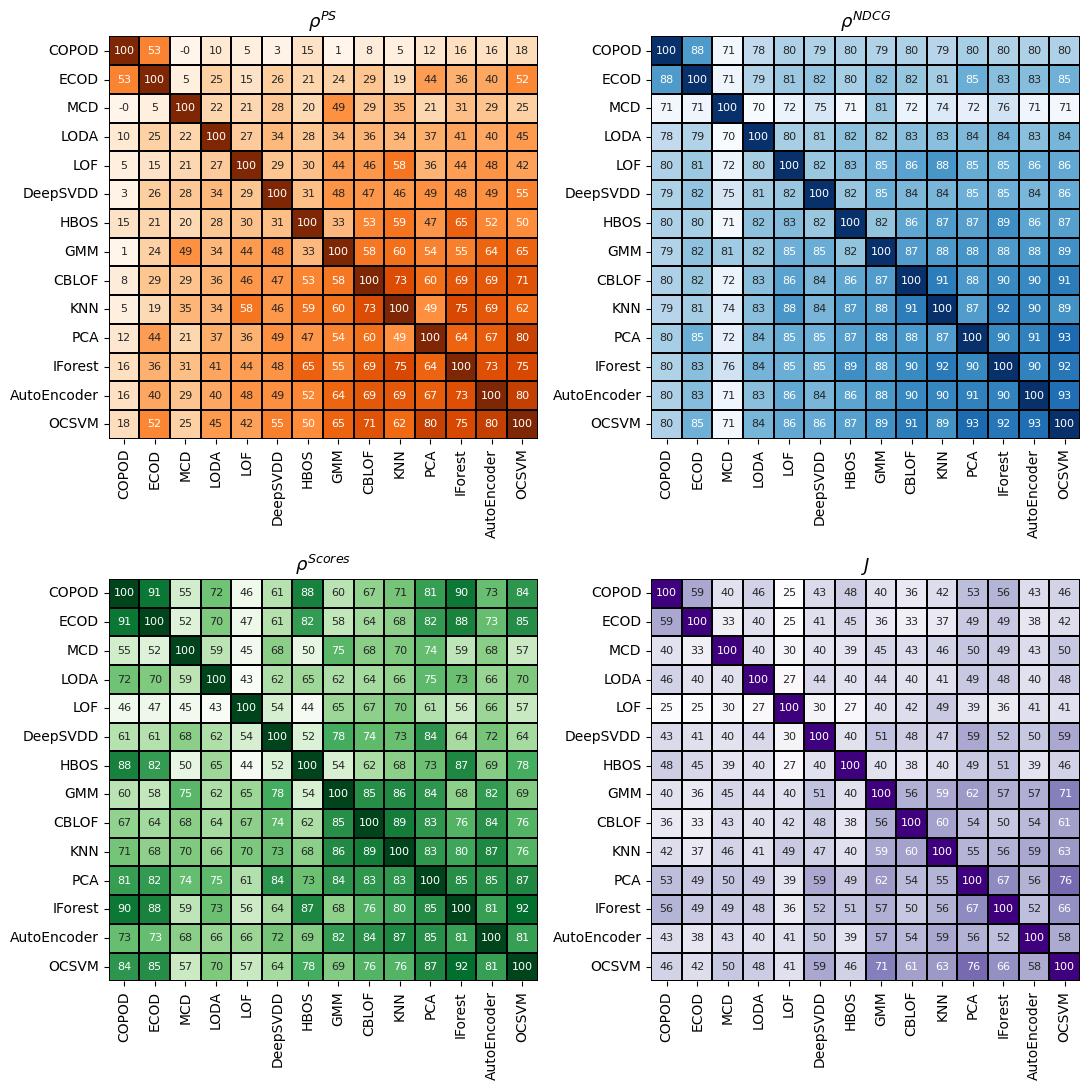

In [5]:
all_matrices = {
    "Pearson SHAP": all_pearson,
    "NDCG SHAP": all_ndcg,
    "Pearson scores": all_corr_score,
    "Jaccard preds": all_jaccard,
}

df_dict = {}
for name, mat_list in all_matrices.items():
    mean_mat = np.nanmean(np.array(mat_list), axis=0)
    df_dict[name] = pd.DataFrame(mean_mat * 100, index=model_names, columns=model_names)

dist_matrix = 100 - df_dict["Pearson SHAP"].values
linkage = sch.linkage(dist_matrix, method="average")
dendro = sch.dendrogram(linkage, no_plot=True)
ordered_labels = [df_dict["Pearson SHAP"].index[i] for i in dendro["leaves"]]

for name in df_dict:
    df_dict[name] = df_dict[name].loc[ordered_labels, ordered_labels]

new_dict = {}
new_dict[r"$\rho^{PS}$"] = df_dict["Pearson SHAP"]
new_dict[r"$\rho^{NDCG}$"] = df_dict["NDCG SHAP"]
new_dict[r"$\rho^{Scores}$"] = df_dict["Pearson scores"]
new_dict[r"$J$"] = df_dict["Jaccard preds"]

fig = plot_heatmaps(
    new_dict,
    figsize=(11, 11),
    colormaps=["Oranges", "Blues", "Greens", "Purples", "Reds", "OrRd"],
)

# fig.savefig("matrices.eps", format="eps", bbox_inches="tight", pad_inches=0.1)

In [19]:
from skbio.stats.distance import mantel

matrices_dist = [1 - np.nanmean(m, axis=0) for m in all_matrices.values()]
names = list(all_matrices.keys())

n = len(matrices_dist)
mantel_corrs = np.zeros((n, n))
mantel_pvals = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        corr, pval, _ = mantel(matrices_dist[i], matrices_dist[j], permutations=10000)
        mantel_corrs[i, j] = mantel_corrs[j, i] = corr
        mantel_pvals[i, j] = mantel_pvals[j, i] = pval

df_corr = pd.DataFrame(mantel_corrs, index=names, columns=names)
df_pval = pd.DataFrame(mantel_pvals, index=names, columns=names)

print("Mantel correlation matrix:")
print(df_corr.round(2))
print("\n")
print("Mantel p-value matrix:")
print(df_pval.round(3))

Mantel correlation matrix:
                Pearson SHAP  NDCG SHAP  Pearson scores  Jaccard preds
Pearson SHAP            1.00       0.83            0.55           0.67
NDCG SHAP               0.83       1.00            0.54           0.57
Pearson scores          0.55       0.54            1.00           0.76
Jaccard preds           0.67       0.57            0.76           1.00


Mantel p-value matrix:
                Pearson SHAP  NDCG SHAP  Pearson scores  Jaccard preds
Pearson SHAP           0.000      0.000           0.001          0.000
NDCG SHAP              0.000      0.000           0.004          0.003
Pearson scores         0.001      0.004           0.000          0.000
Jaccard preds          0.000      0.003           0.000          0.000


In [23]:
dataset_names = list(all_results.keys())

correlations = {}

for i, dataset_name in enumerate(dataset_names):

    matrices_dist = [1 - all_matrices[name][i] for name in all_matrices.keys()]

    correlations[dataset_name] = [
        mantel(matrices_dist[0], matrices_dist[2])[0],
        mantel(matrices_dist[0], matrices_dist[3])[0],
    ]


df = pd.DataFrame.from_dict(
    correlations, orient="index", columns=["corr(pshap_pscores)", "corr(pshap_jaccard)"]
)
df[["corr(pshap_pscores)", "corr(pshap_jaccard)"]] *= 100

df.round()

,corr(pshap_pscores),corr(pshap_jaccard)
2_annthyroid,75.0,78.0
4_breastw,22.0,51.0
14_glass,42.0,24.0
15_Hepatitis,26.0,51.0
21_Lymphography,36.0,84.0
23_mammography,56.0,51.0
27_PageBlocks,33.0,66.0
29_Pima,55.0,52.0
37_Stamps,56.0,53.0
38_thyroid,72.0,76.0
